In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import csv
from astropy.io import ascii
import pandas as pd
import pickle
Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline


### Test

In [2]:
centre = '16:38:00, -59:50:00'  
coordinate = centre.replace(',', '')
c = SkyCoord(coordinate, unit=(u.hourangle, u.deg))
print(c)
path_hi = SkyView.get_images(position=centre, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi = path_hi[0]
d = hdulist_hi[0].data
h = hdulist_hi[0].header

<SkyCoord (ICRS): (ra, dec) in deg
    (249.5, -59.83333333)>


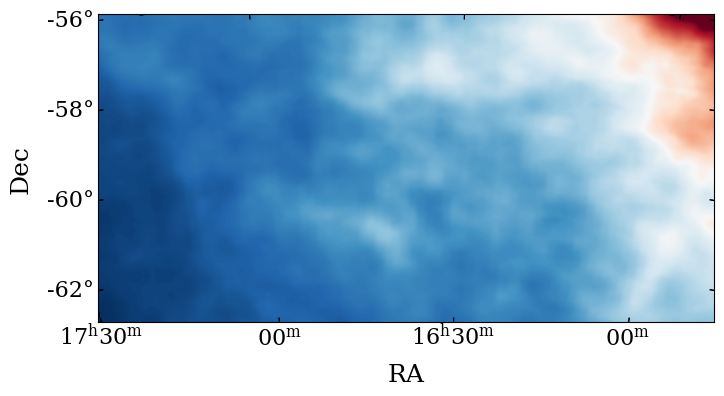

In [3]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1, projection=WCS(h))
ax.imshow(d,cmap='RdBu_r', vmax=np.percentile(d, 99.8))
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

## Sources

In [2]:
def plot_continuum_cat(field, centre):

    data = pd.read_csv(f'ATCA_HI_spectra/{field}_coords.csv')

    sources = pd.DataFrame(data)
    
    ra = np.array(sources['ra (hms)'])
    dec = np.array(sources['dec (dms)'])
    ra_deg = np.array(sources['ra (deg)'])
    dec_deg = np.array(sources['dec (deg)'])

    # select continuum sources to plot

    coordinate = centre.replace(',', '')
    c = SkyCoord(coordinate, unit=(u.hourangle, u.deg))
    print(c)
    path_hi = SkyView.get_images(position=centre, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
    hdulist_hi = path_hi[0]
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    # plot figure
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))

    # Display the moment map image
    im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d,99.9))
    #im = ax.imshow(d, cmap='bone_r', vmax=np.percentile(d,99.99))
    #ax.contour(co_reprojected, levels=[0.4, 0.8], cmap='Blues_r', alpha=0.7)

    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), marker='x', s=100, c='k', linewidths=2)

    #ax.set_title('Hydra', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)

    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    cbar_hi.set_label('N(HI)', size=18)

    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)

    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    #plt.colorbar(im)
    #fig.savefig('{}_ASKAP_continuum_sources_v2.png'.format(field),dpi=200)

<SkyCoord (ICRS): (ra, dec) in deg
    (157.25, -27.59027778)>


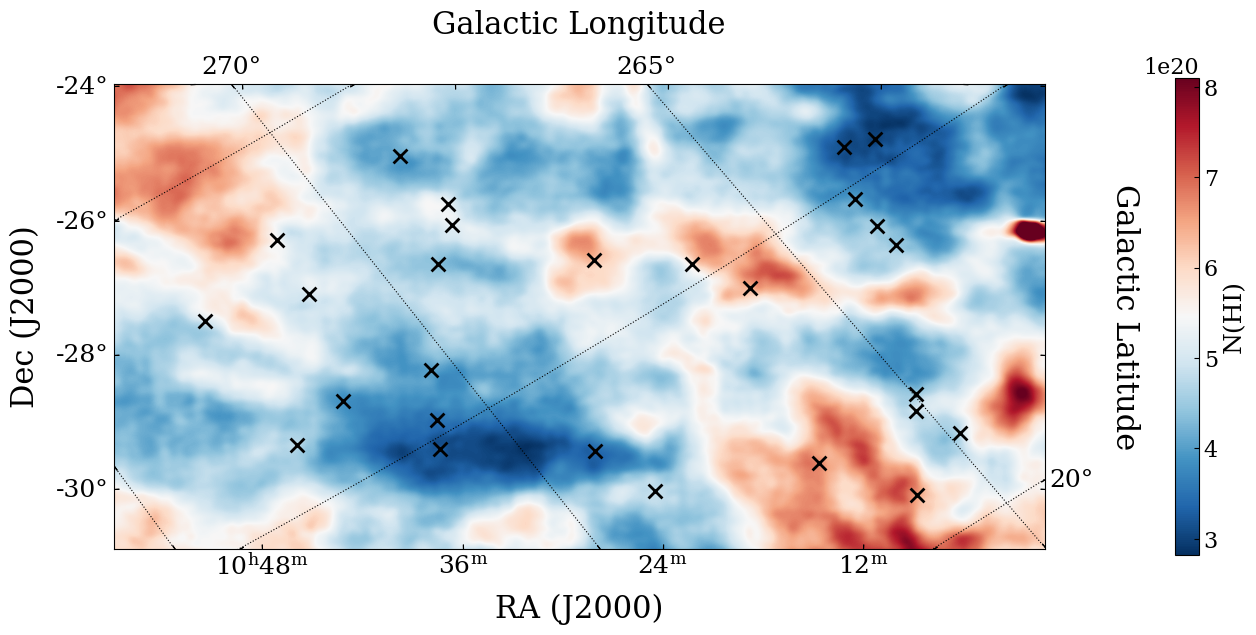

In [3]:
plot_continuum_cat('hydra', '10:29:00, -27:35:25')


<SkyCoord (ICRS): (ra, dec) in deg
    (249.5, -59.83333333)>


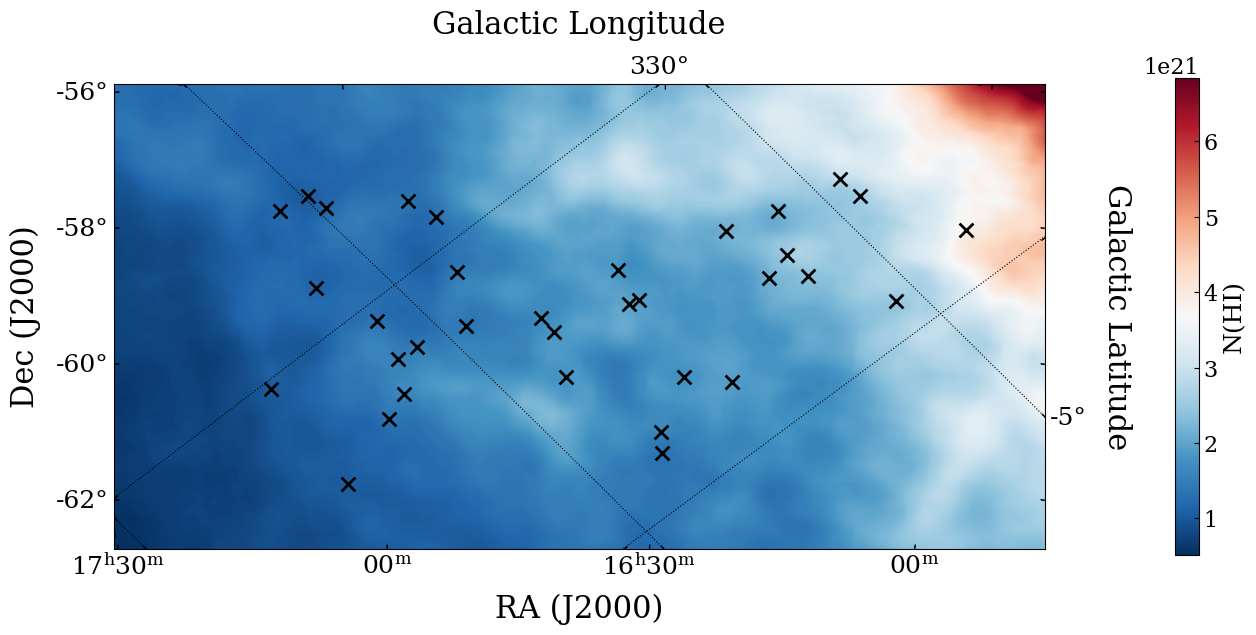

In [4]:
plot_continuum_cat('norma', '16:38:00, -59:50:00')


## Tau

In [2]:
sources_h = pd.read_csv(f'ATCA_HI_spectra/hydra_coords.csv', index_col=0)
ra_h = np.array(sources_h['ra (hms)'])
dec_h = np.array(sources_h['dec (dms)'])
ra_deg_h = np.array(sources_h['ra (deg)'])
dec_deg_h = np.array(sources_h['dec (deg)'])
centre_h = '10:29:00, -27:35:25'
coordinate_h = centre_h.replace(',', '')
c_h = SkyCoord(coordinate_h, unit=(u.hourangle, u.deg))
path_hi_h = SkyView.get_images(position=centre_h, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_h = path_hi_h[0]

sources_n = pd.read_csv(f'ATCA_HI_spectra/norma_coords.csv', index_col=0)
ra_n = np.array(sources_n['ra (hms)'])
dec_n = np.array(sources_n['dec (dms)'])
ra_deg_n = np.array(sources_n['ra (deg)'])
dec_deg_n = np.array(sources_n['dec (deg)'])
centre_n = '16:38:00, -59:50:00'
coordinate_n = centre_n.replace(',', '')
c_n = SkyCoord(coordinate_n, unit=(u.hourangle, u.deg))
path_hi_n = SkyView.get_images(position=centre_n, width=12*u.deg, height=7*u.deg, survey=['HI4PI'], pixels=[1800,900])
hdulist_hi_n = path_hi_n[0]


In [3]:
with open('Decomposition/dictv2_h.pkl', 'rb') as f:
    dict_v2_h = pickle.load(f)
with open('Decomposition/dictv2_n.pkl', 'rb') as f:
    dict_v2_n = pickle.load(f)

# with open('Decomposition/dict4k_n.pkl', 'rb') as f:
#     dict_4k_n = pickle.load(f)
# with open('Decomposition/dictv2_n.pkl', 'rb') as f:
#     dict_v2_n = pickle.load(f)

In [23]:
len(dict_v2_n)

27

In [4]:
def get_amplitude(source_name, source_dict):
    return source_dict.get(source_name, {}).get('amp', None)

In [5]:
# Apply the function with a lambda to pass the dictionary
sources_h['ampv2'] = sources_h['source'].apply(lambda source_name: get_amplitude(source_name, dict_v2_h))
sources_n['ampv2'] = sources_n['source'].apply(lambda source_name: get_amplitude(source_name, dict_v2_n))

# sources_n['amp4k'] = sources_n['source'].apply(lambda source_name: get_amplitude(source_name, dict_4k_n))
# sources_n['ampv2'] = sources_n['source'].apply(lambda source_name: get_amplitude(source_name, dict_v2_n))

In [6]:
sources_n

,source,ra (deg),dec (deg),ra (hms),dec (dms),ampv2
0,j171029-6041,257.620833,-60.688056,17:10:28.99999464,-60:41:16.99998396,"[0.4863, 0.3215, 0.0637, 0.3946, 0.1006, 0.034..."
1,j163405-5908,248.520833,-59.137500,16:34:04.99999368,-59:08:14.99991792,"[1.2359, 1.7156, 0.912, 0.4676, 0.4542, 0.4343]"
2,j162909-6133,247.288333,-61.562500,16:29:09.19999392,-61:33:45.00004968,"[0.3438, 0.2642]"
3,j161257-5737,243.237500,-57.619444,16:12:56.99999568,-57:37:10.00005672,"[1.9646, 1.1939, 0.6784, 0.6865]"
5,j161717-5848,244.320833,-58.802500,16:17:17.0000016,-58:48:08.99991684,[0.7335]
6,j170418-5751,256.075833,-57.850833,17:04:18.19999368,-57:51:03.00006396,None
7,j160559-5921,241.496667,-59.355278,16:05:59.20000104,-59:21:19.00007064,"[1.1874, 0.8904, 0.4577, 0.3935, 0.4181, 0.386..."
8,j160011-5810,240.049583,-58.180000,16:00:11.89999704,-58:10:48.00003924,"[1.304, 0.7536]"
9,j165016-5908,252.567917,-59.137778,16:50:16.30000368,-59:08:16.00009584,None
10,j164939-5956,252.412917,-59.943056,16:49:39.09999456,-59:56:34.99996884,None


In [7]:
# Function to get the maximum value of a list
def get_max_value(lst):
    if lst == None:
        return 0
    else:
        return max(lst)

In [8]:
sources_h['max_ampv2'] = sources_h['ampv2'].apply(get_max_value)
sources_n['max_ampv2'] = sources_n['ampv2'].apply(get_max_value)

In [9]:
sources_n

,source,ra (deg),dec (deg),ra (hms),dec (dms),ampv2,max_ampv2
0,j171029-6041,257.620833,-60.688056,17:10:28.99999464,-60:41:16.99998396,"[0.4863, 0.3215, 0.0637, 0.3946, 0.1006, 0.034...",0.4863
1,j163405-5908,248.520833,-59.137500,16:34:04.99999368,-59:08:14.99991792,"[1.2359, 1.7156, 0.912, 0.4676, 0.4542, 0.4343]",1.7156
2,j162909-6133,247.288333,-61.562500,16:29:09.19999392,-61:33:45.00004968,"[0.3438, 0.2642]",0.3438
3,j161257-5737,243.237500,-57.619444,16:12:56.99999568,-57:37:10.00005672,"[1.9646, 1.1939, 0.6784, 0.6865]",1.9646
5,j161717-5848,244.320833,-58.802500,16:17:17.0000016,-58:48:08.99991684,[0.7335],0.7335
6,j170418-5751,256.075833,-57.850833,17:04:18.19999368,-57:51:03.00006396,None,0.0000
7,j160559-5921,241.496667,-59.355278,16:05:59.20000104,-59:21:19.00007064,"[1.1874, 0.8904, 0.4577, 0.3935, 0.4181, 0.386...",1.1874
8,j160011-5810,240.049583,-58.180000,16:00:11.89999704,-58:10:48.00003924,"[1.304, 0.7536]",1.3040
9,j165016-5908,252.567917,-59.137778,16:50:16.30000368,-59:08:16.00009584,None,0.0000
10,j164939-5956,252.412917,-59.943056,16:49:39.09999456,-59:56:34.99996884,None,0.0000


In [10]:
def plot_continuum_tau(hdulist_hi, ra_deg, dec_deg, tau):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))
    
    # Display the moment map image
    im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d,99.9))
    
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    
    im2 = ax.scatter(ra_deg, dec_deg, transform=ax.get_transform('fk5'), \
                     marker='o', s=100, linewidth=2, edgecolor='k', c=tau, \
                     cmap='plasma', vmin=0, vmax=np.max(tau), alpha=0.8)
    
    #ax.set_title('Hydra', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
    
    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    cbar_hi.set_label('N(HI)', size=18)
    cbar_hi2 = plt.colorbar(im2, orientation='vertical', fraction=0.02, pad=0.12)
    cbar_hi2.set_label(r'$\tau$', size=18)
    
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

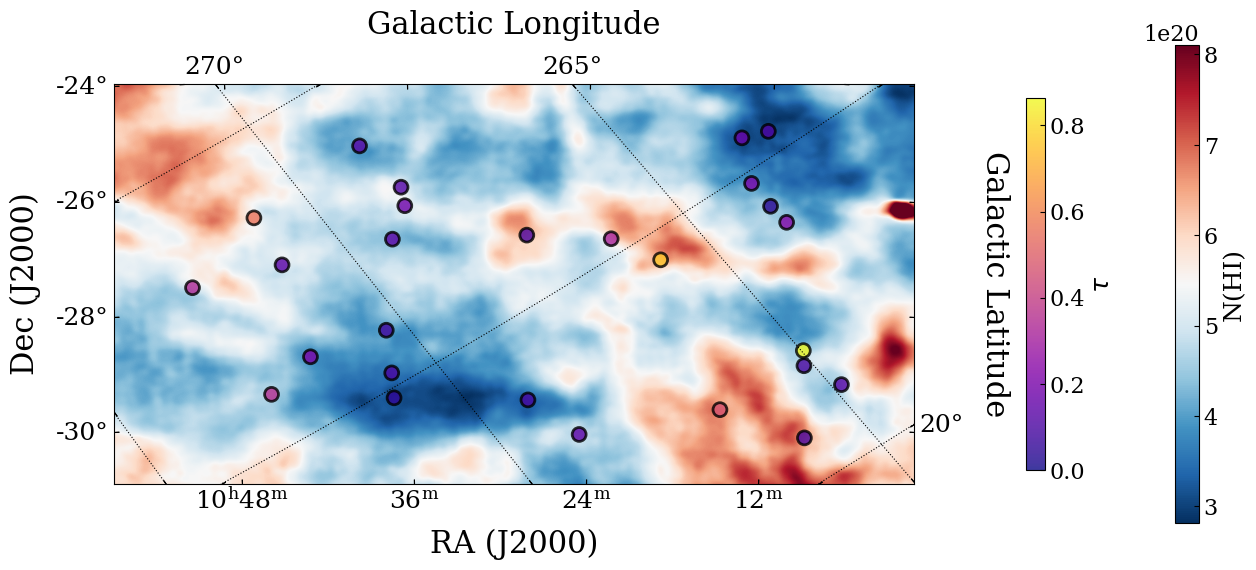

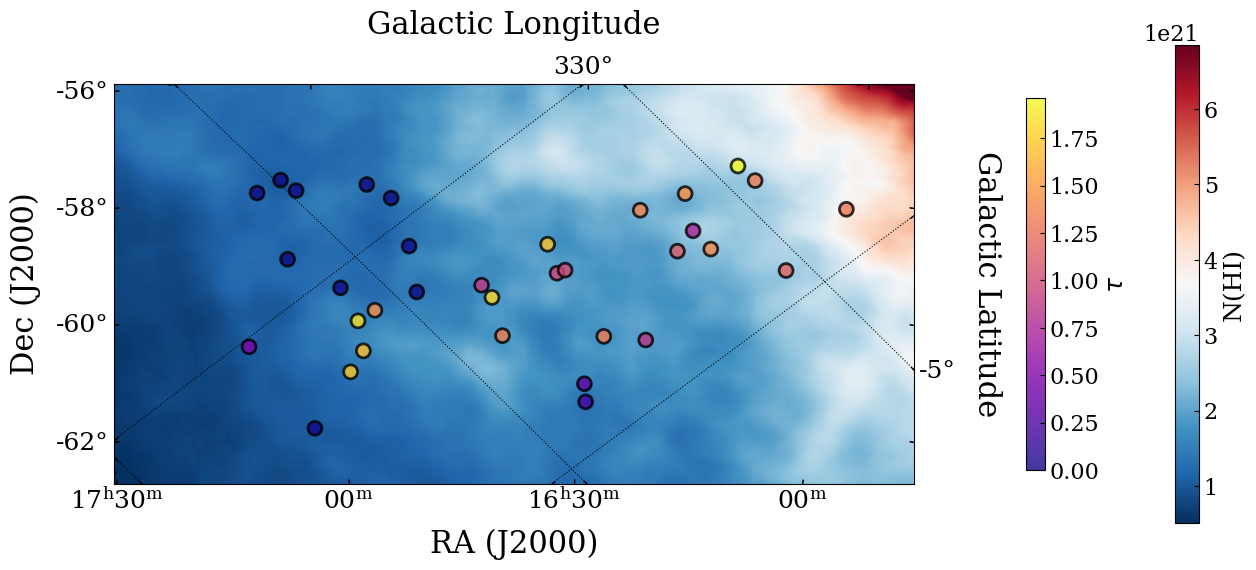

In [11]:
plot_continuum_tau(hdulist_hi_h, ra_deg_h, dec_deg_h, sources_h['max_ampv2'])
plot_continuum_tau(hdulist_hi_n, ra_deg_n, dec_deg_n, sources_n['max_ampv2'])

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs import WCS

def plot_continuum_tau2(hdulist_hi, ra_deg, dec_deg, tau):
    d = hdulist_hi[0].data
    h = hdulist_hi[0].header

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection=WCS(h))
    
    # Display the moment map image
    im = ax.imshow(d, cmap='RdBu_r', vmax=np.percentile(d, 99.9))
    
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    
    # Plot multiple circles per source to represent different amplitudes
    for i, (ra, dec) in enumerate(zip(ra_deg, dec_deg)):
        amplitudes = tau.iloc[i] # Get the amplitudes for the source, removing NaNs
        print(amplitudes)
        if amplitudes != None:
            max_amp = np.max(amplitudes)  # For color normalization     
            for j, amp in enumerate(amplitudes):
                circle = plt.Circle((ra, dec), (j + 1) * size_factor, transform=ax.get_transform('fk5'), 
                                    edgecolor='k', facecolor=plt.cm.plasma(amp / max_amp), 
                                    linewidth=2, alpha=0.6 / (j + 1))
                ax.add_patch(circle)
    
    # Axis labels and title
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
    ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
    
    # Colorbars
    cbar_hi = plt.colorbar(im, orientation='vertical', fraction=0.022, pad=0.12)
    cbar_hi.set_label('N(HI)', size=18)
    
    # Optional: Add colorbar for amplitudes if needed
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=max_amp))
    sm.set_array([])
    #cbar_amp = plt.colorbar(sm, orientation='vertical', fraction=0.02, pad=0.12)
    #cbar_amp.set_label(r'$\tau$ Amplitudes', size=18)
    
    # Galactic overlay
    overlay = ax.get_coords_overlay('galactic')
    overlay.grid(color='k', ls='dotted')
    overlay[0].set_axislabel('Galactic Longitude', fontsize=22)
    overlay[1].set_axislabel('Galactic Latitude', fontsize=22)
    overlay[0].tick_params(axis='both', which='major', labelsize=18)
    overlay[1].tick_params(axis='both', which='major', labelsize=18)
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    plt.show()



[0.4863, 0.3215, 0.0637, 0.3946, 0.1006, 0.0347, 0.0601]


NameError: name 'size_factor' is not defined

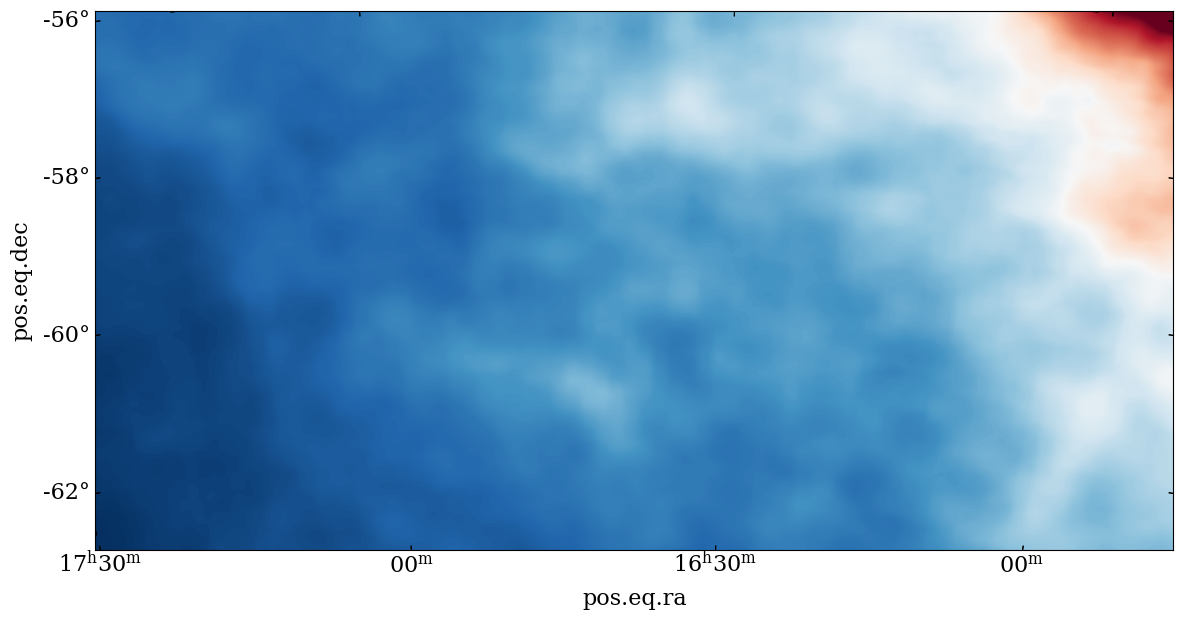

In [38]:
plot_continuum_tau2(hdulist_hi_n, ra_deg_n, dec_deg_n, sources_n['ampv2'])